*coding=utf-8*

文件名: segment.ipynb

作者: Theia-4869 (Qizhe Zhang)

说明: 本文件是 segment.py 的逐步演示

In [1]:
import math
import numpy as np
import cv2
from matplotlib import pyplot as plt

读入原始图片并灰度化

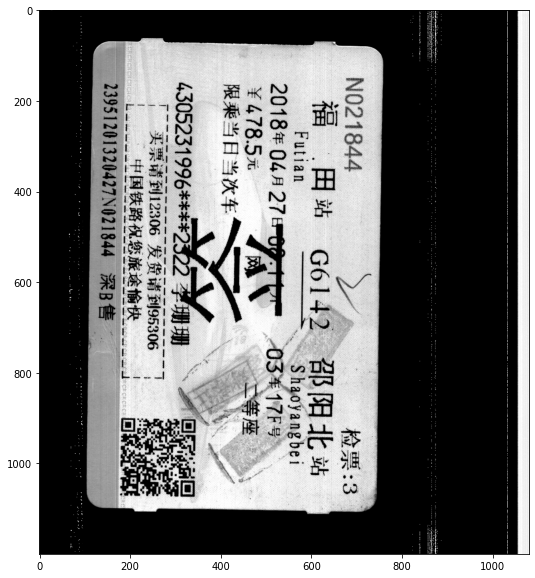

In [2]:
original_img = cv2.imread('training_data/2018-5-22-18-4-51.bmp')
gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 10))
plt.imshow(gray_img, cmap="gray")
plt.show()

# Stage 1: Face Detection

二值化 (阈值: 127)

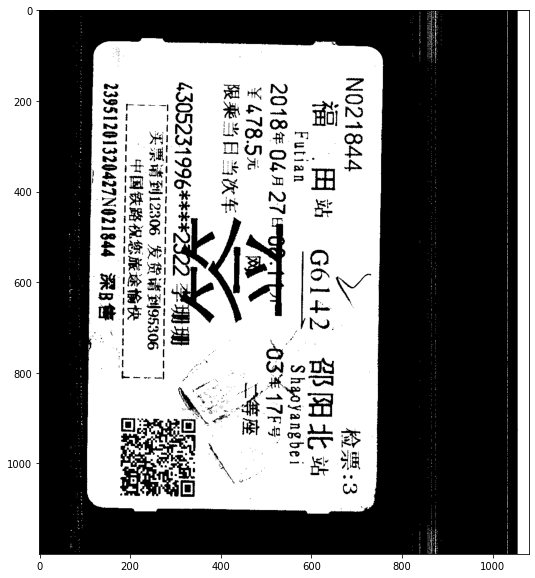

In [3]:
binary_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)[1]

plt.figure(figsize=(10, 10))
plt.imshow(binary_img, cmap="gray")
plt.show()

中值滤波 (kernel大小: 7)

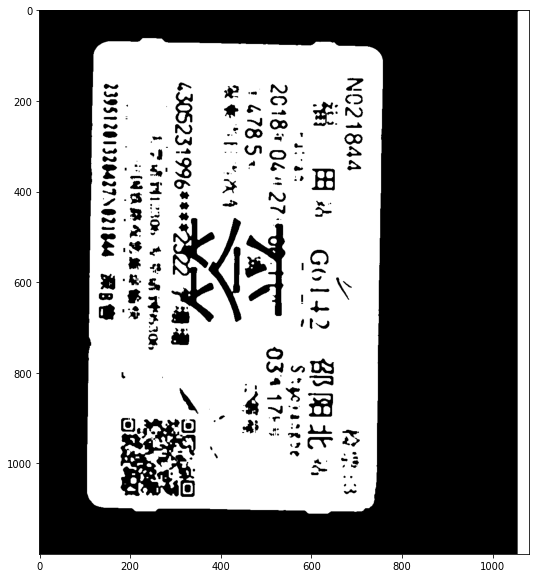

In [4]:
median_img = cv2.medianBlur(binary_img, 7)

plt.figure(figsize=(10, 10))
plt.imshow(median_img, cmap="gray")
plt.show()


形态学处理 (开:7-闭:70-开:70) 去除票面上的文字与线条

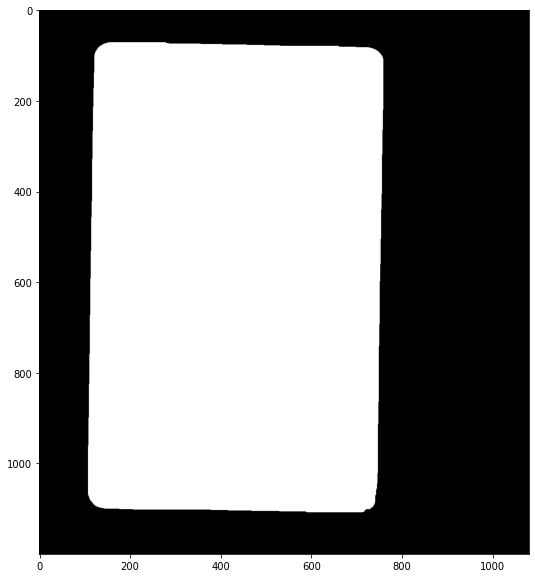

In [5]:
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (70, 70))
mor_img = cv2.morphologyEx(median_img, cv2.MORPH_OPEN, kernel1) 
mor_img = cv2.morphologyEx(mor_img, cv2.MORPH_CLOSE, kernel2)
mor_img = cv2.morphologyEx(mor_img, cv2.MORPH_OPEN, kernel2)

plt.figure(figsize=(10, 10))
plt.imshow(mor_img, cmap="gray")
plt.show()

根据形态学处理后的结果绘制票面最小矩形包围盒并将票面转正

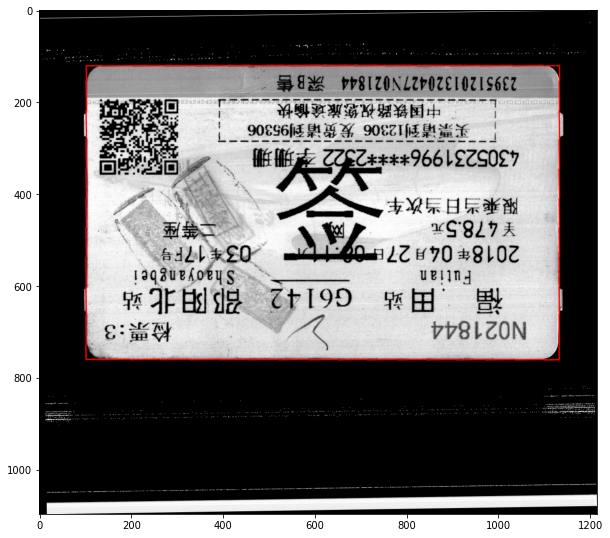

In [6]:
coords = np.column_stack(np.where(mor_img > 0))
rect = cv2.minAreaRect(coords)
box_ = np.int0(cv2.boxPoints(rect))
box = np.zeros(box_.shape, dtype=np.int64)
box[:, 0] = box_[:, 1]
box[:, 1] = box_[:, 0]
box_img = cv2.drawContours(original_img.copy(), [box], -1, (0, 0, 255), 2)

h, w = mor_img.shape
cx, cy = w/2, h/2
if rect[1][0] < rect[1][1]:
    angle = -rect[2]
else:
    angle = -rect[2] - 90
M = cv2.getRotationMatrix2D(center=(cx, cy), angle=angle, scale=1.0)
new_h = int(w * math.fabs(math.sin(math.radians(angle))) + h * math.fabs(math.cos(math.radians(angle))))
new_w = int(h * math.fabs(math.sin(math.radians(angle))) + w * math.fabs(math.cos(math.radians(angle))))
M[0, 2] += (new_w - w) / 2
M[1, 2] += (new_h - h) / 2
upright_img = cv2.warpAffine(original_img, M, (new_w, new_h), borderValue=(0, 0, 0))
upright_mor_img = cv2.warpAffine(mor_img, M, (new_w, new_h), borderValue=(0, 0, 0))
upright_box_img = cv2.warpAffine(box_img, M, (new_w, new_h), borderValue=(0, 0, 0))

plt.figure(figsize=(10,10))
plt.imshow(upright_box_img[:,:,::-1])
plt.show()

根据上下部分的灰度判断票面是否倒置, 若是则翻转180°

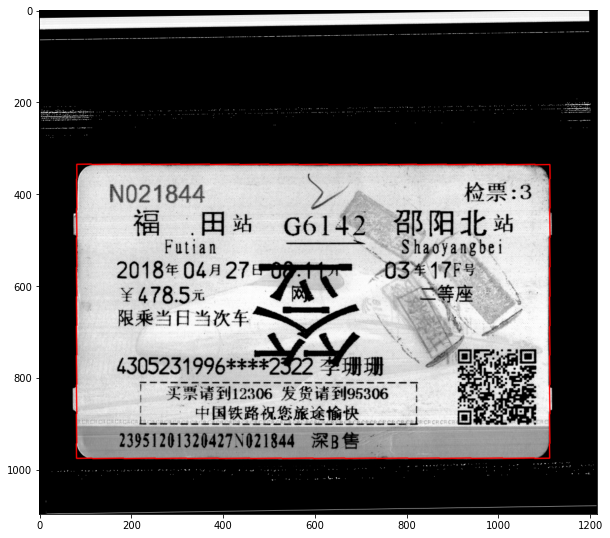

In [7]:
gray_upright_img = cv2.cvtColor(upright_img, cv2.COLOR_BGR2GRAY)
plus_img = cv2.threshold(gray_upright_img, 127, 255, cv2.THRESH_BINARY)[1] - cv2.threshold(gray_upright_img, 200, 255, cv2.THRESH_BINARY)[1]
erode_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
plus_img = cv2.erode(plus_img, erode_kernel)

if np.sum(plus_img[:h//2, :]) > np.sum(plus_img[h//2:, :]):
    upright_img = cv2.flip(upright_img, -1)
    upright_mor_img = cv2.flip(upright_mor_img, -1)
    upright_box_img = cv2.flip(upright_box_img, -1)

plt.figure(figsize=(10,10))
plt.imshow(upright_box_img[:,:,::-1])
plt.show()

将票面单独分割出来并统一缩放为 1080×640 大小

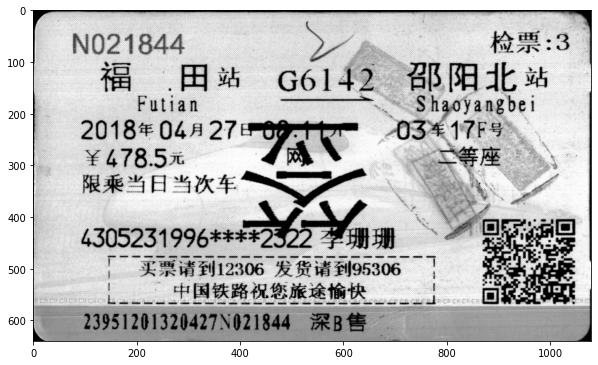

In [8]:
coords = np.column_stack(np.where(upright_mor_img > 0))
rect = cv2.minAreaRect(coords)
box = np.int0(cv2.boxPoints(rect))

h_min = np.min(box[:, 0])
h_max = np.max(box[:, 0])
w_min = np.min(box[:, 1])
w_max = np.max(box[:, 1])
select_img = upright_img[h_min:h_max, w_min:w_max]
face_img = cv2.resize(select_img, (1080, 640), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(10,10))
plt.imshow(face_img, cmap="gray")
plt.show()

# Stage 2: Serial Number Segmentation

# 21 Number

灰度化, 高斯模糊 (kernel大小: 5), 二值化 (阈值: 30), 初步定位21位码大致区域

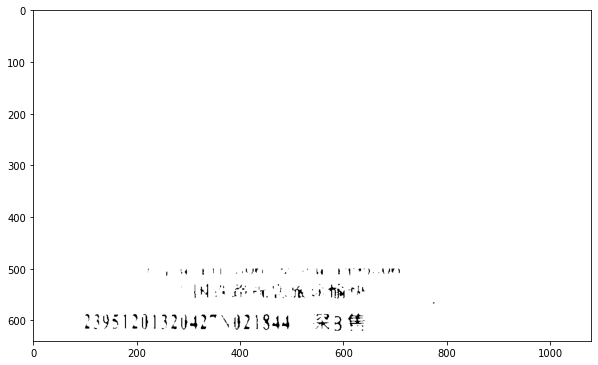

In [9]:
gray_img_21 = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
gaussian_img_21 = cv2.GaussianBlur(gray_img_21, (5, 5), 0)
binary_img_21 = cv2.threshold(gaussian_img_21, 30, 255, cv2.THRESH_BINARY)[1]

mask_21 = np.ones(binary_img_21.shape, dtype=np.uint8)
mask_21[500:620, 20:800] = 0
img_21 = cv2.add(binary_img_21, mask_21 * 255)

plt.figure(figsize=(10, 10))
plt.imshow(img_21, cmap="gray")
plt.show()

两阶段精细定位21位码区域

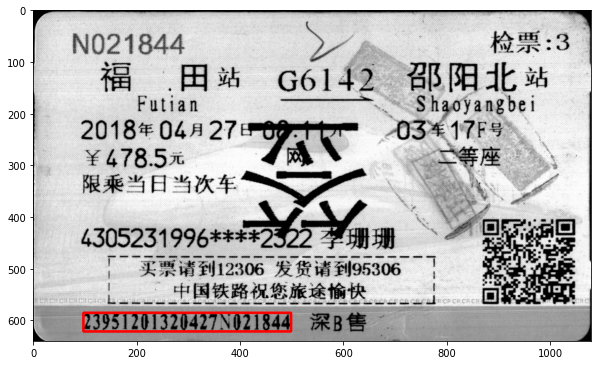

In [10]:
coords_21 = np.column_stack(np.where(img_21 < 255))
rect_21 = cv2.minAreaRect(coords_21)
box_21_ = np.int0(cv2.boxPoints(rect_21))
box_21_ = box_21_[np.lexsort(np.rot90(box_21_))]
h_max_21 = np.max(box_21_[:, 0])
w_min_21 = np.min(box_21_[:, 1])
img_21[:h_max_21-40, :] = 255
img_21[:, w_min_21+405:] = 255

coords_21 = np.column_stack(np.where(img_21 < 255))
rect_21 = cv2.minAreaRect(coords_21)
box_21_ = np.int0(cv2.boxPoints(rect_21))
box_21_ = box_21_[np.lexsort(np.rot90(box_21_))]
h_min_21 = np.min(box_21_[:, 0]) - 3
h_max_21 = np.max(box_21_[:, 0]) + 3
w_min_21 = np.min(box_21_[:, 1]) - 4
w_max_21 = np.max(box_21_[:, 1]) + 4
box_21 = np.array([[w_min_21, h_min_21], [w_min_21, h_max_21], [w_max_21, h_max_21], [w_max_21, h_min_21]], dtype=np.int64)

face_img_21 = cv2.drawContours(face_img.copy(), [box_21], -1, (0, 0, 255), 3)
face_img_21_copy = face_img_21.copy()

plt.figure(figsize=(10, 10))
plt.imshow(face_img_21[:,:,::-1])
plt.show()

用掩模提取21位码区域以待分割

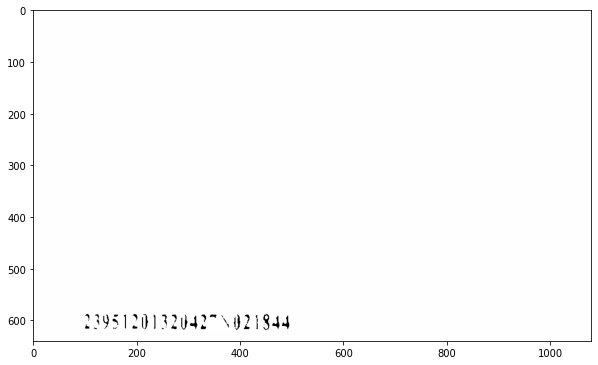

In [11]:
mask_21 = np.ones(img_21.shape, dtype=np.uint8)
mask_21[h_min_21:h_max_21, w_min_21:w_max_21] = 0
mask_box_21 = np.add(img_21,  mask_21 * 255)

plt.figure(figsize=(10, 10))
plt.imshow(mask_box_21, cmap="gray")
plt.show()

根据连通域以自适应间距精细分割21位码, 若21位都被单独分离, 则分割完成

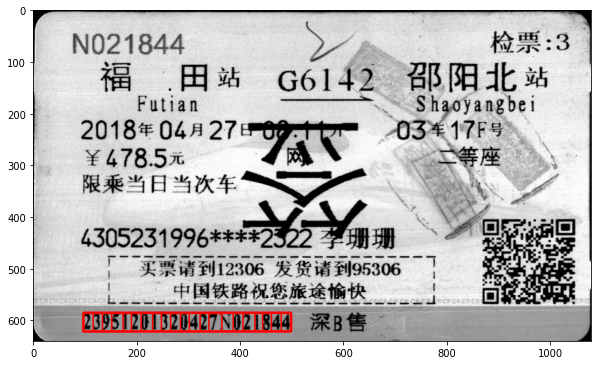

In [12]:

contours, hierarchy = cv2.findContours(mask_box_21, 2, 2)
x_min = 2000
x_list = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if x != 0 and y != 0 and w*h >= 40:
        x_list.append(x)
        if x < x_min:
            x_min = x
x_list.sort()
x_list.pop(0)
y_list = [w_min_21+4]
line_num_21 = 0
for i in range(len(x_list)):
    if line_num_21 == 14:
        dist_min = 20
    elif line_num_21 == 13:
        x_list[i] -= 2
    else:
        dist_min = 10
    if x_list[i] > x_min + dist_min:
        cv2.line(face_img_21_copy, (x_list[i]-1, h_min_21), (x_list[i]-1, h_max_21), (0, 0, 255), 2)
        x_min = x_list[i]
        y_list.append(x_list[i])
        line_num_21 += 1
y_list.append(w_max_21)
if line_num_21 == 20:
    face_img_21 = face_img_21_copy

plt.figure(figsize=(10, 10))
plt.imshow(face_img_21[:,:,::-1])
plt.show()

否则, 采用等距分割以保证程序鲁棒性

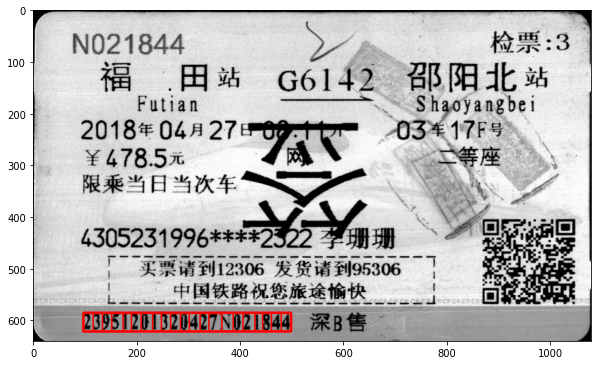

In [13]:
if line_num_21 != 20:
    interval = (w_max_21 - w_min_21 - 6) / 21.5
    dist = 0
    y_list = [w_min_21+4]
    for i in range(20):
        if i == 14:
            dist += interval * 1.5
        else:
            dist += interval
        cv2.line(face_img_21, (w_min_21+3+np.int0(dist), h_min_21), (w_min_21+3+np.int0(dist), h_max_21), (0, 0, 255), 2)
        y_list.append(w_min_21+4+np.int0(dist))
    y_list.append(w_max_21-2)

plt.figure(figsize=(10, 10))
plt.imshow(face_img_21[:,:,::-1])
plt.show()

展示分割结果

22
[101, 117, 135, 153, 175, 191, 210, 232, 249, 267, 286, 303, 324, 341, 366, 388, 407, 430, 445, 462, 481, 499]


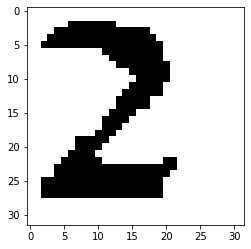

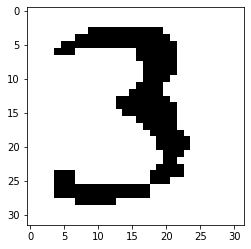

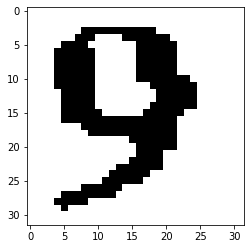

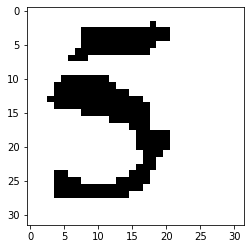

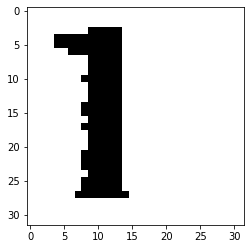

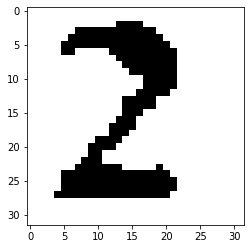

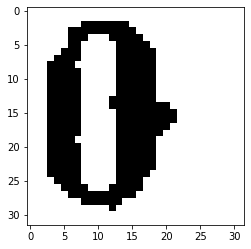

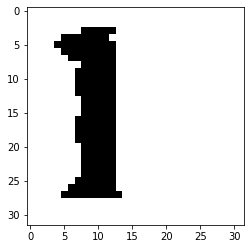

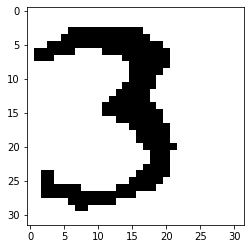

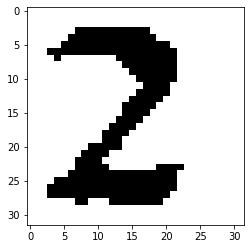

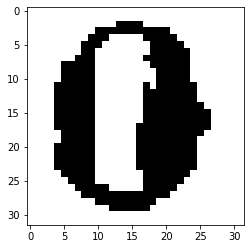

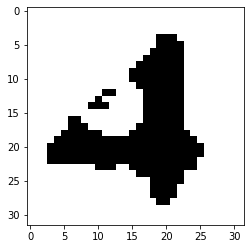

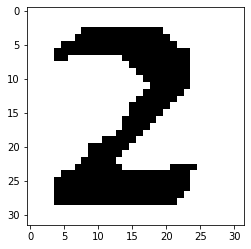

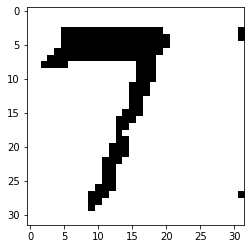

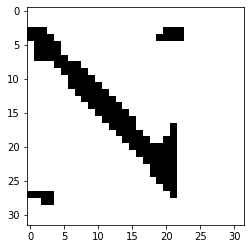

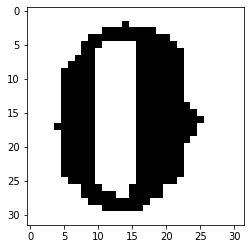

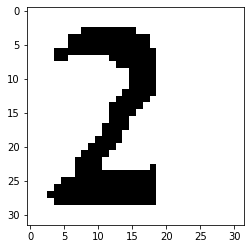

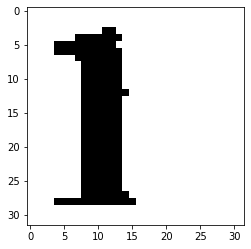

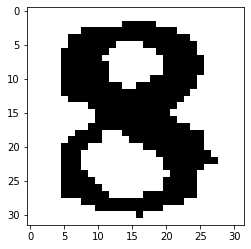

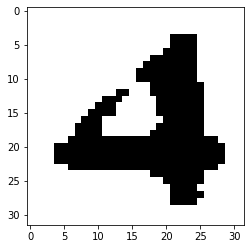

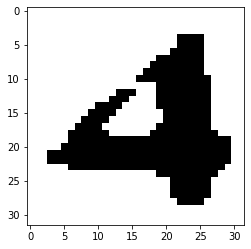

In [14]:
print(len(y_list))
print(y_list)
for i in range(21):
    code_21 = face_img[h_min_21:h_max_21, y_list[i]-2:y_list[i+1]-1]
    code_21 = cv2.resize(code_21, (32, 32), interpolation=cv2.INTER_CUBIC)
    code_21 = cv2.threshold(code_21, 40, 255, cv2.THRESH_BINARY)[1]
    plt.figure()
    plt.imshow(code_21, cmap="gray")
    plt.show()

## 7 Number

灰度化, 双阈值二值化 (阈值: 50, 140)

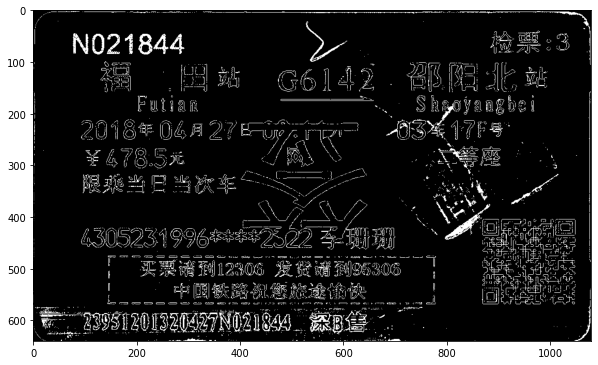

In [15]:
gray_img_7 = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
binary_img_7 = cv2.threshold(gray_img_7, 50, 255, cv2.THRESH_BINARY)[1] - cv2.threshold(gray_img_7, 140, 255, cv2.THRESH_BINARY)[1]

plt.figure(figsize=(10, 10))
plt.imshow(binary_img_7, cmap="gray")
plt.show()

形态学操作 (腐蚀:2-闭:9) 去噪

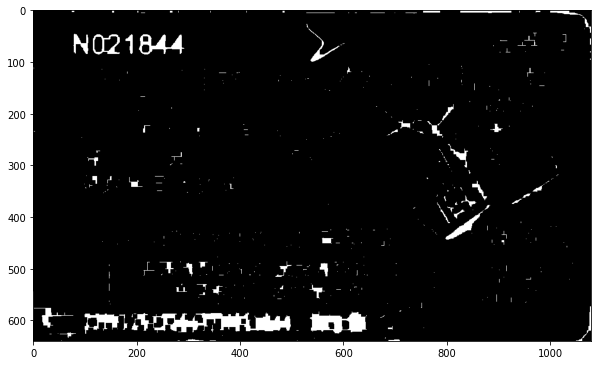

In [16]:
erode_kernel_7 = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
mor_img_7 = cv2.erode(binary_img_7, erode_kernel_7)
close_kernel_7 = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
mor_img_7 = cv2.morphologyEx(mor_img_7, cv2.MORPH_CLOSE, close_kernel_7)

plt.figure(figsize=(10, 10))
plt.imshow(mor_img_7, cmap="gray")
plt.show()

在票面左上角粗定位7位码

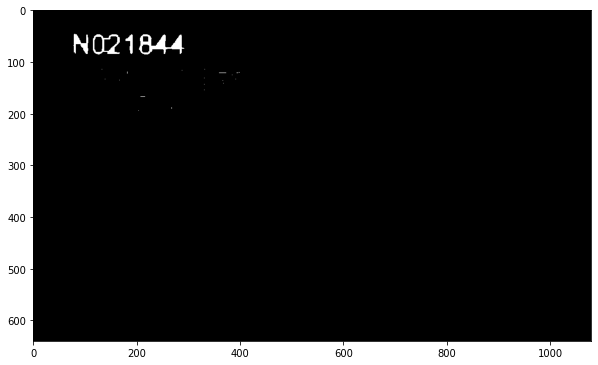

In [17]:
mask_7 = np.zeros(mor_img_7.shape, dtype=np.uint8)
mask_7[10:200, 20:400] = 1
mask_img_7 = mor_img_7 * mask_7

plt.figure(figsize=(10, 10))
plt.imshow(mask_img_7, cmap="gray")
plt.show()

根据连通域大小 (<150) 进一步去噪

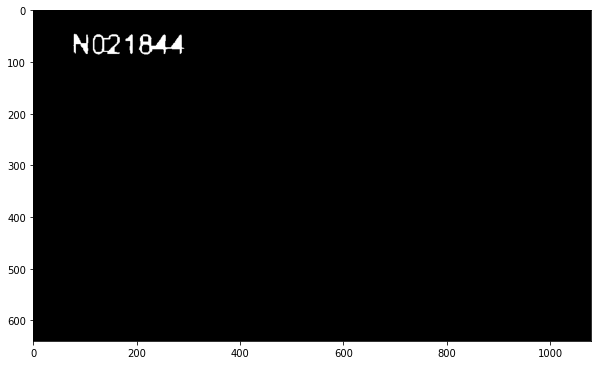

In [18]:
retval, labels, stats, _ = cv2.connectedComponentsWithStats(mask_img_7, connectivity=8)
img_7 = mask_img_7.copy()
for i in range(retval):
    if stats[i][4] < 150:
        img_7[labels==i] = 0

plt.figure(figsize=(10, 10))
plt.imshow(img_7, cmap="gray")
plt.show()

以粗定位为基准精细定位7位码

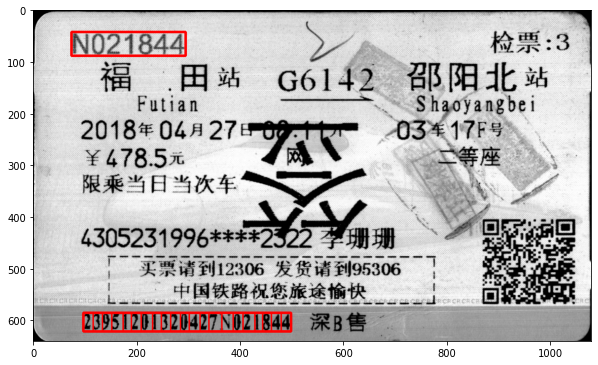

In [19]:
coords_7 = np.column_stack(np.where(img_7 > 0))
rect_7 = cv2.minAreaRect(coords_7)
box_7_ = np.int0(cv2.boxPoints(rect_7))
box_7_ = box_7_[np.lexsort(np.rot90(box_7_))]
h_min_7 = np.min(box_7_[:, 0]) - 3
h_max_7 = np.max(box_7_[:, 0]) + 3
w_min_7 = np.min(box_7_[:, 1]) - 3
w_max_7 = np.max(box_7_[:, 1]) + 3
box_7 = np.array([[w_min_7, h_min_7], [w_min_7, h_max_7], [w_max_7, h_max_7], [w_max_7, h_min_7]], dtype=np.int64)

face_img_7 = cv2.drawContours(face_img_21, [box_7], -1, (0, 0, 255), 3)

plt.figure(figsize=(10,10))
plt.imshow(face_img_7[:,:,::-1])
plt.show()

用掩模提取7位码区域以待分割

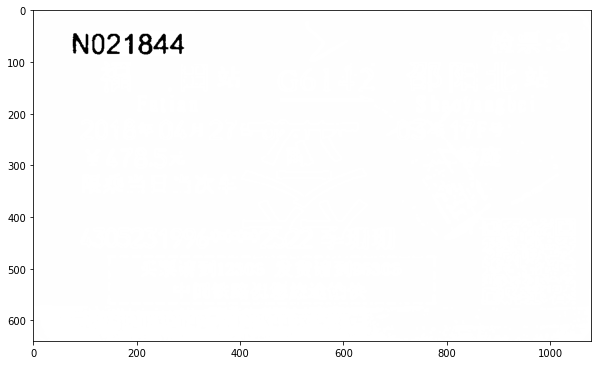

In [20]:
binary_img_7 = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
binary_img_7 = cv2.medianBlur(binary_img_7, 3)
binary_img_7 = cv2.threshold(binary_img_7, 50, 255, cv2.THRESH_BINARY)[1] - cv2.threshold(binary_img_7, 150, 255, cv2.THRESH_BINARY)[1]
binary_img_7 = 255 - binary_img_7
mask_7 = np.ones(binary_img_7.shape, dtype=np.uint8)
mask_7[h_min_7:h_max_7, w_min_7:w_max_7] = 0
mask_box_7 = np.add(binary_img_7,  mask_7 * 255)
face_img_21_copy = face_img_21.copy()
plt.figure(figsize=(10, 10))
plt.imshow(mask_box_7, cmap="gray")
plt.show()

根据连通域以自适应间距精细分割7位码, 若7位都被单独分离, 则分割完成

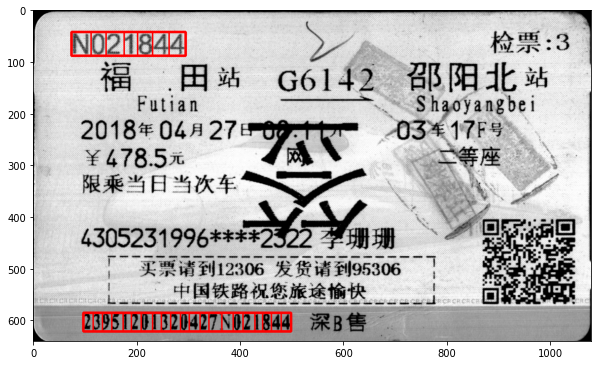

In [21]:
contours, hierarchy = cv2.findContours(mask_box_7, 2, 2)
x_min = 2000
x_list = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if x != 0 and y != 0 and w*h >= 200:
        x_list.append(x)
        if x < x_min:
            x_min = x
x_list.sort()
x_list.pop(0)
y_list = [w_min_7+3]
line_num_7 = 0
for i in range(len(x_list)):
    if x_list[i] > x_min + 20:
        cv2.line(face_img_21_copy, (x_list[i]-1, h_min_7), (x_list[i]-1, h_max_7), (0, 0, 255), 2)
        x_min = x_list[i]
        y_list.append(x_list[i])
        line_num_7 += 1
y_list.append(w_max_7)
if line_num_7 == 6:
    face_img_21 = face_img_21_copy
plt.figure(figsize=(10, 10))
plt.imshow(face_img_21[:,:,::-1])
plt.show()

否则, 采用等距分割以保证程序鲁棒性

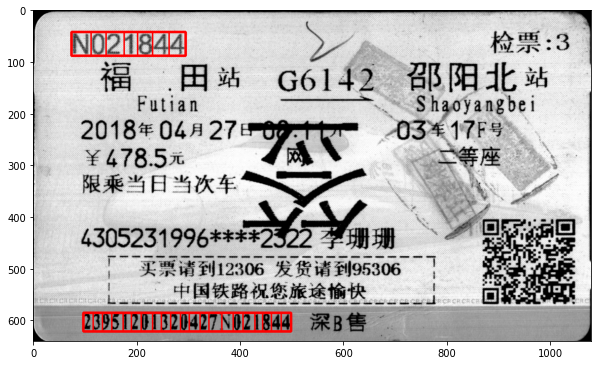

In [22]:
if line_num_7 != 6:
    interval = (w_max_7 - w_min_7 - 6) / 7.5
    dist = 0
    y_list = [w_min_7+3]
    for i in range(6):
        if i == 0:
            dist += interval * 1.5
        else:
            dist += interval
        cv2.line(face_img_21, (w_min_7+3+np.int0(dist), h_min_7), (w_min_7+3+np.int0(dist), h_max_7), (0, 0, 255), 2)
        y_list.append(w_min_7+3+np.int0(dist))
    y_list.append(w_max_7)
plt.figure(figsize=(10, 10))
plt.imshow(face_img_21[:,:,::-1])
plt.show()

展示分割结果

8
[77, 113, 142, 177, 203, 232, 264, 295]


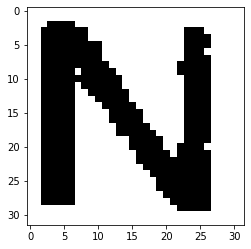

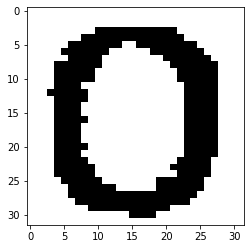

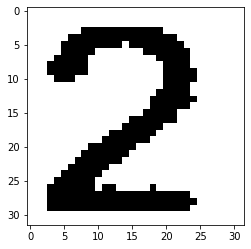

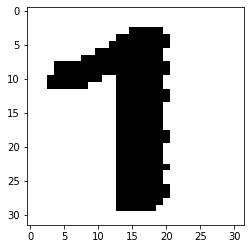

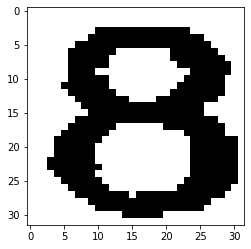

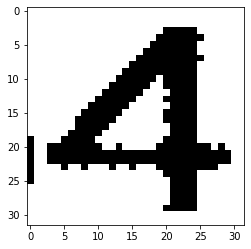

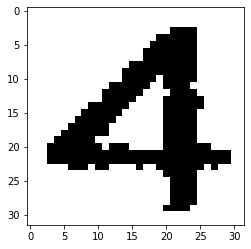

In [23]:
print(len(y_list))
print(y_list)
for i in range(7):
    code_7 = face_img[h_min_7:h_max_7, y_list[i]-2:y_list[i+1]]
    code_7 = cv2.resize(code_7, (32, 32), interpolation=cv2.INTER_CUBIC)
    code_7 = cv2.threshold(code_7, 150, 255, cv2.THRESH_BINARY)[1]
    plt.figure()
    plt.imshow(code_7, cmap="gray")
    plt.show()